In [69]:
import SALib
import numpy as np
import pandas as pd
import re, os
import time
import matplotlib.pyplot as plt
from adjustText import adjust_text

Colorblind-friendly palette

In [79]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [80]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [81]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


BRICK parameters are the same for all scenarios because they are calibrated in hindcast.

In [82]:
brickdir = "https://zenodo.org/record/6626335/files/parameters_subsample_sneasybrick.csv"
dfPB = pd.read_csv(brickdir)

SSP-RCP scenarios and a dictionary to hold the sensitivity results from Method of Morris:

In [83]:
surge_option = 0
scenarios = [(1,26),(2,45),(4,60),(5,85)]
dfSi = {scen : None for scen in scenarios}

Directories where all the BRICK-CIAM results are, for all the different SSP-RCP scenarios.

In [103]:
for (ssp, rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC = dfSC.join(pd.read_csv(bothdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv"))
    dfPC = pd.read_csv(bothdir+"/trials_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv",
                       names = ["movefactor","dvbm","vslel","vslmult","wvel","wvpdl"], header=0)

    tmp = dfPB.iloc[dfSC.brickEnsInd]
    tmp.reset_index(inplace=True, drop=True)
    dfP = pd.concat([tmp,dfPC], axis=1)
        
    n_ensemble, n_parameter = dfP.shape
    mins = list(dfP.min())
    maxs = list(dfP.max())
    bounds = [[mins[i],maxs[i]] for i in range(n_parameter)]

    problem = {"num_vars" : n_parameter,
               "names" : list(dfP.columns),
               "bounds" : bounds}

    X = np.array(dfP)[:986,:]
    Y = np.array(dfSC.npv)[:986]
    dfSi[(ssp,rcp)] = pd.DataFrame(SALib.analyze.morris.analyze(problem, X, Y, print_to_console=False))
    dfSi[(ssp,rcp)]["dist"] = np.sqrt(dfSi[(ssp,rcp)].mu_star**2 + dfSi[(ssp,rcp)].sigma**2)
    

* dvbm = FUND value of OECD dryland per Darwin et al 1995 converted from $1995 ($2010M per sqkm) (5.376)
* wvel = income elasticity of wetland value (1.16) (Brander et al, 2006)
* movefactor = Cost to relocate mobile capital as a fraction of asset value (0.1)
* vslel = Elasticity of vsl (0.5) (only used for endogenous calculation of vsl)
* vslmult = multiplier on USA GDP (216)(only used for endogenous calculation of vsl)
* wvpdl = Population density elasticity of wetland value (0.47) (Brander et al, 2

In [104]:
top = 8
for scen in scenarios:
    print("================================")
    print(scen)
    print(dfSi[scen].sort_values(by="mu_star", ascending=False)[["names","mu_star"]][:top])

(1, 26)
                  names       mu_star
52                 dvbm  20967.342562
55                 wvel   5879.730739
25      CO2_diffusivity   5521.745552
10        rho_greenland   5421.156006
13           alpha0_CO2   5377.004894
28  climate_sensitivity   5189.764296
51           movefactor   4920.722021
2           sd_glaciers   4763.421734
(2, 45)
              names       mu_star
52             dvbm  26370.773888
55             wvel  17659.023327
53            vslel  10300.679502
56            wvpdl   9539.593454
7   rho_temperature   9135.686743
38  antarctic_gamma   9047.973856
14            CO2_0   8977.089476
5           sd_gmsl   8440.419013
(4, 60)
                names       mu_star
52               dvbm  26666.784299
55               wvel  12704.371533
42  antarctic_precip0   7544.739062
53              vslel   7079.391453
35         glaciers_n   6896.367859
44    antarctic_flow0   6764.195193
33     greenland_beta   6757.277686
0             sd_temp   6656.572096
(5, 

In [105]:
scen = (5,85)
top = 8
print(dfSi[scen].sort_values(by="mu_star", ascending=False)[["names","mu_star"]][:top])
print()
print(dfSi[scen].sort_values(by="dist", ascending=False)[["names","mu_star"]][:top])

                       names       mu_star
52                      dvbm  45530.850258
55                      wvel  30601.648281
36                anto_alpha  15034.941553
41              antarctic_nu  14157.421614
45  antarctic_runoff_height0  13827.252312
51                movefactor  13756.439303
23                       Q10  13566.026466
6       sigma_whitenoise_co2  13503.949174

                       names       mu_star
52                      dvbm  45530.850258
55                      wvel  30601.648281
36                anto_alpha  15034.941553
41              antarctic_nu  14157.421614
45  antarctic_runoff_height0  13827.252312
24         CO2_fertilization  13227.871158
53                     vslel  13482.938200
6       sigma_whitenoise_co2  13503.949174


In [97]:
dfSi[(5,85)].sort_values(by="mu_star", ascending=False).iloc[:8]

,names,mu,mu_star,sigma,mu_star_conf,dist
52,dvbm,45530.850258,45530.850258,9786.053858,5109.987640,46570.647143
55,wvel,-30601.648281,30601.648281,11307.203043,5424.994025,32623.821330
36,anto_alpha,4250.335492,15034.941553,17653.871635,4984.814787,23188.545690
41,antarctic_nu,4571.472263,14157.421614,16994.644237,4427.381990,22119.008104
45,antarctic_runoff_height0,1117.783084,13827.252312,17153.600557,4471.721839,22032.678425
51,movefactor,8326.580867,13756.439303,14881.027897,4293.020061,20265.355007
23,Q10,-7237.548027,13566.026466,16355.545854,5297.565582,21249.493035
6,sigma_whitenoise_co2,-1517.620485,13503.949174,16426.007512,4281.836735,21264.297921


In [98]:
dfSi[(5,85)].sort_values(by="dist", ascending=False).iloc[:8]

,names,mu,mu_star,sigma,mu_star_conf,dist
52,dvbm,45530.850258,45530.850258,9786.053858,5109.987640,46570.647143
55,wvel,-30601.648281,30601.648281,11307.203043,5424.994025,32623.821330
36,anto_alpha,4250.335492,15034.941553,17653.871635,4984.814787,23188.545690
41,antarctic_nu,4571.472263,14157.421614,16994.644237,4427.381990,22119.008104
45,antarctic_runoff_height0,1117.783084,13827.252312,17153.600557,4471.721839,22032.678425
24,CO2_fertilization,-628.443841,13227.871158,16983.526916,4561.691163,21527.116897
53,vslel,-485.415617,13482.938200,16595.487414,4583.390260,21382.231525
6,sigma_whitenoise_co2,-1517.620485,13503.949174,16426.007512,4281.836735,21264.297921


In [133]:
ciam_params = list(dfP.columns[-6:]); print(ciam_params)

['movefactor', 'dvbm', 'vslel', 'vslmult', 'wvel', 'wvpdl']


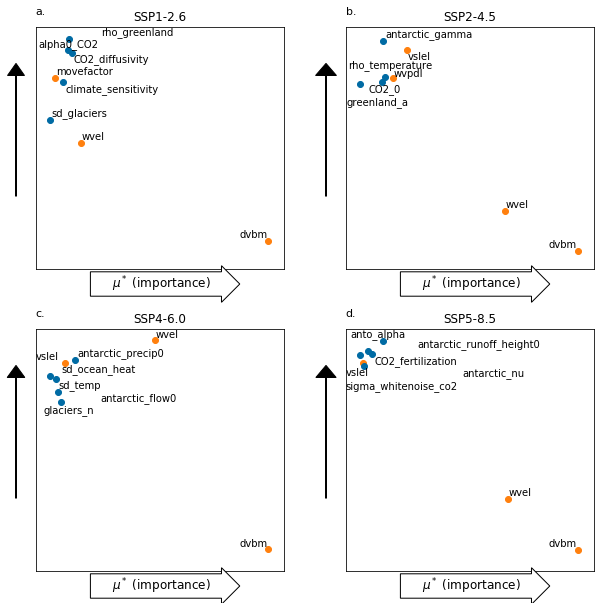

In [172]:
#top = len(dfSi[(1,26)])
top = 8
scen_labels = ["SSP1-2.6","SSP2-4.5","SSP4-6.0","SSP5-8.5"]
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]
colors = {"SLR":"C0", "SE":"C1"}

fig, ax = plt.subplots(2,2,figsize=(10,10))
fig.subplots_adjust(hspace=.25,wspace=0.25)
for s in range(len(scenarios)):
    scen = scenarios[s]
    row,col = int(s/2), s%2
    names  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["names"])
    mustar = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["mu_star"])
    sigma  = list(dfSi[scen].sort_values(by="dist", ascending=False).iloc[:top]["sigma"])
    for i in range(top):
        color = colors["SE"] if (names[i] in ciam_params) else colors["SLR"]
        ax[row][col].scatter(np.log10(mustar[i]),np.log10(sigma[i]), color=color)
    ax[row][col].set_title(scen_labels[s], fontsize=12);
    ax[row][col].set_xticks([]); ax[row][col].set_yticks([])
    xlims = ax[row][col].get_xlim(); xrange = np.diff(xlims)[0]
    ylims = ax[row][col].get_ylim(); yrange = np.diff(ylims)[0]
    ax[row][col].text(xlims[0], ylims[1]+0.05*yrange, panels[s], fontsize=11)
    annotations = []
    for i in range(top):
        annotations.append(ax[row][col].text(np.log10(mustar[i]),np.log10(sigma[i]),names[i]))
    adjust_text(annotations,x=np.log10(mustar),y=np.log10(sigma),ax=ax[row][col],expand_align=(1.2,1.2))
    
    bbox_props = dict(boxstyle="rarrow, pad=0.2", fc="white", ec="black", lw=1)
    ax[row][col].text(xlims[0]+0.5*xrange,ylims[0]-0.08*yrange, 5*' '+'$\\mu^*$ (importance)'+5*' ',
                      fontsize=12,bbox=bbox_props,ha="center")
    ax[row][col].arrow(xlims[0]-0.08*xrange, ylims[0]+0.3*yrange,
                       0, 0.5*yrange, head_width=0.05, head_length=0.05*yrange, fc='k', ec='k', clip_on=False)
#    bbox_props = dict(boxstyle="rarrow, pad=0.2", fc="white", ec="black", lw=1, rotation=90)
#    ax[row][col].text(xlims[0]-0.08*xrange,ylims[0]+0.5*yrange, 5*' '+'$\\sigma$ (interaction)'+5*' ',
#                      fontsize=12,bbox=bbox_props,va="center")

fig.savefig(plotdir+"/sensitivity_ssprcp.pdf", bbox_inches='tight');


In [167]:
xrange

array([0.73080662])

In [166]:
xlims[0]+0.08*xrange, ylims[0]+0.3*yrange,         0.5*xrange, ylims[0]+0.5*yrange

(array([3.69451656]),
 array([3.69403018]),
 array([0.36540331]),
 array([3.73035692]))

In [ ]:
y

In [ ]:
def find_coords(start, prev):
    if len(prev)==0:
        return start
    coords = start
    

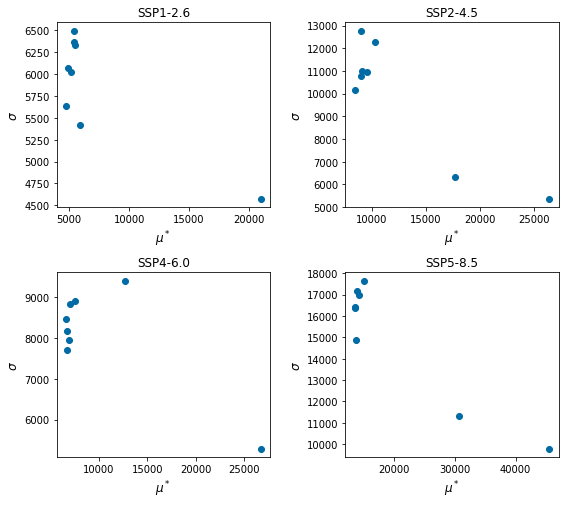

In [91]:
#top = len(dfSi[(1,26)])
top = 8
scen_labels = ["SSP1-2.6","SSP2-4.5","SSP4-6.0","SSP5-8.5"]

fig, ax = plt.subplots(2,2,figsize=(9,8))
fig.subplots_adjust(hspace=.35,wspace=0.35)
for s in range(len(scenarios)):
    scen = scenarios[s]
    row,col = int(s/2), s%2
    names  = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["names"])
    mustar = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["mu_star"])
    sigma  = list(dfSi[scen].sort_values(by="mu_star", ascending=False).iloc[:top]["sigma"])
    ax[row][col].scatter(mustar,sigma)
    ax[row][col].set_xlabel("$\\mu^*$", fontsize=12);
    ax[row][col].set_ylabel("$\\sigma$", fontsize=12);
    ax[row][col].set_title(scen_labels[s], fontsize=12);
        